# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Generic matching code applied to sources

In this notebook the maximum likelihood cross-match between the LOFAR HETDEX catalogue and the combined PansSTARRS WISE catalogue is computed. 

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os

In [3]:
from mltier1 import (get_center, Field, MultiMLEstimatorU, parallel_process, get_sigma_all, describe)

In [4]:
%load_ext autoreload

In [5]:
%autoreload

In [6]:
from IPython.display import clear_output

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### General configuration

In [8]:
save_intermediate = True
plot_intermediate = True

In [9]:
idp = "idata/final_pdf_v0.9"

In [10]:
if not os.path.isdir(idp):
    os.makedirs(idp)

### Area limits

In [11]:
# Busy week Edinburgh 2017
ra_down = 172.09
ra_up = 187.5833
dec_down = 46.106
dec_up = 56.1611

In [12]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [13]:
# Full field July 2017
ra_down = 160.
ra_up = 232.
dec_down = 42.
dec_up = 62.

In [14]:
field = Field(170.0, 190.0, 46.8, 55.9)

In [15]:
field_full = Field(160.0, 232.0, 42.0, 62.0)

## Load data

In [16]:
combined_all = Table.read("pw.fits")

In [17]:
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fixed.fits")
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_merge_ID_optical_v0.8.fits")

In [18]:
np.array(combined_all.colnames)

array(['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 'W1mag',
       'W1magErr', 'i', 'iErr'], dtype='<U8')

In [19]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'E_RA_tot', 'DEC', 'E_DEC',
       'E_DEC_tot', 'Peak_flux', 'E_Peak_flux', 'E_Peak_flux_tot',
       'Total_flux', 'E_Total_flux', 'E_Total_flux_tot', 'Maj', 'E_Maj',
       'Min', 'E_Min', 'PA', 'E_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID',
       'Isl_id'], dtype='<U16')

### Filter catalogues

The following line has been corrected in the latest versions to use all the sources, including the extended. Hence the running of the "-extended" version of this notebook is no longer necessary.

In [20]:
lofar = field_full.filter_catalogue(lofar_all, colnames=("RA", "DEC"))

In [21]:
combined = field_full.filter_catalogue(combined_all, 
                               colnames=("ra", "dec"))

### Additional data

In [22]:
combined["colour"] = combined["i"] - combined["W1mag"]

In [23]:
combined_aux_index = np.arange(len(combined))

### Sky coordinates

In [24]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [25]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

In [26]:
combined_matched = (~np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Matched i-W1 sources

In [27]:
combined_panstarrs = (~np.isnan(combined["i"]) & np.isnan(combined["W1mag"])) # Sources with only i-band

In [28]:
combined_wise =(np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Sources with only W1-band

In [29]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise
#combined_only_i = combined_panstarrs & ~combined_matched
#combined_only_w1 = combined_wise & ~combined_matched

In [30]:
print("Total    - ", len(combined))
print("i and W1 - ", np.sum(combined_matched))
print("Only i   - ", np.sum(combined_panstarrs))
print("With i   - ", np.sum(combined_i))
print("Only W1  - ", np.sum(combined_wise))
print("With W1  - ", np.sum(combined_w1))

Total    -  26674548
i and W1 -  8196213
Only i   -  13454849
With i   -  21651062
Only W1  -  5023475
With W1  -  13219688


### Colour categories

The colour categories will be used after the first ML match

In [31]:
colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [32]:
# Start with the W1-only, i-only and "less than lower colour" bins
colour_bin_def = [{"name":"only W1", "condition": combined_wise},
                  {"name":"only i", "condition": combined_panstarrs},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

/home/jsm/programs/soft/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/jsm/programs/soft/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [33]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

In [34]:
np.sum(np.isnan(combined["category"]))

11

We get the number of sources of the combined catalogue in each colour category. It will be used at a later stage to compute the $Q_0$ values

In [35]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [36]:
numbers_combined_bins

array([ 5023475, 13454849,  1048864,   679553,   911508,   654963,
         774322,   830266,   804997,   713558,   580621,   438821,
         309428,   319368,    95816,    34128])

## Maximum Likelihood

In [37]:
bin_list, centers, Q_0_colour, n_m, q_m = pickle.load(open("lofar_params.pckl", "rb"))

In [38]:
likelihood_ratio_function = MultiMLEstimatorU(Q_0_colour, n_m, q_m, centers)

### ML match

In [39]:
radius = 15

In [40]:
selection = ~np.isnan(combined["category"]) # Avoid the dreaded sources with no actual data
catalogue = combined[selection]

In [41]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["i"][idx_0]
    mag[category == 0] = catalogue["W1mag"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = catalogue["raErr"][idx_0]
    c_dec_err = catalogue["decErr"][idx_0]
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, sigma_maj, sigma_min, category)
    
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

### Run the cross-match

In [42]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [43]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [44]:
import multiprocessing
n_cpus_total = multiprocessing.cpu_count()
n_cpus = max(1, n_cpus_total-1)

In [45]:
def ml(i):
    return apply_ml(i, likelihood_ratio_function)

In [46]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 312k/312k [4:12:03<00:00, 20.6it/s]
100%|██████████| 311874/311874 [00:00<00:00, 430902.00it/s]


In [68]:
lofar["lr"] = np.nan                   # Likelihood ratio
lofar["lr_dist"] = np.nan              # Distance to the selected source
lofar["lr_index"] = np.nan             # Index of the PanSTARRS source in combined

In [69]:
(lofar["lr_index"][idx_lofar_unique], 
 lofar["lr_dist"][idx_lofar_unique], 
 lofar["lr"][idx_lofar_unique]) = list(map(list, zip(*res)))

In [70]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

### Threshold and selection

In [71]:
lofar["lrt"] = lofar["lr"]
lofar["lrt"][np.isnan(lofar["lr"])] = 0

In [72]:
q0 = np.sum(Q_0_colour)

In [73]:
def completeness(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr < threshold]
    return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/float(n)/q0

def reliability(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr > threshold]
    return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/float(n)/q0

completeness_v = np.vectorize(completeness, excluded=[0])
reliability_v = np.vectorize(reliability, excluded=[0])

In [74]:
n_test = 100
threshold_mean = np.percentile(lofar["lrt"], 100*(1 - q0))

In [75]:
thresholds = np.arange(0., 10., 0.01)
thresholds_fine = np.arange(0.1, 1., 0.001)

In [76]:
completeness_t = completeness_v(lofar["lrt"], thresholds, q0)
reliability_t = reliability_v(lofar["lrt"], thresholds, q0)
average_t = (completeness_t + reliability_t)/2

In [77]:
completeness_t_fine = completeness_v(lofar["lrt"], thresholds_fine, q0)
reliability_t_fine = reliability_v(lofar["lrt"], thresholds_fine, q0)
average_t_fine = (completeness_t_fine + reliability_t_fine)/2

In [83]:
# Maximum of the average
thresholds_fine[np.argmax(average_t_fine)]

0.3580000000000002

In [84]:
# Crossing point of completeness and reliability
thresholds_fine[np.argmin(np.abs(completeness_t_fine-reliability_t_fine))]

0.5860000000000004

In [85]:
# Value selected for the paper
threshold_sel = 0.639

In [86]:
threshold_sel = 0.639

Text(0,0.5,'Completeness/Reliability')

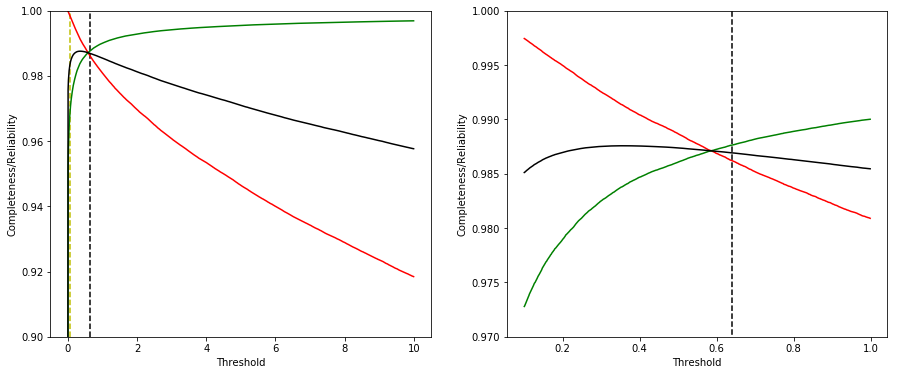

In [87]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
plot(thresholds, completeness_t, "r-")
plot(thresholds, reliability_t, "g-")
plot(thresholds, average_t, "k-")
vlines(threshold_sel, 0.9, 1., "k", linestyles="dashed")
vlines(threshold_mean, 0.9, 1., "y", linestyles="dashed")
ylim([0.9, 1.])
xlabel("Threshold")
ylabel("Completeness/Reliability")
subplot(1,2,2)
plot(thresholds_fine, completeness_t_fine, "r-")
plot(thresholds_fine, reliability_t_fine, "g-")
plot(thresholds_fine, average_t_fine, "k-")
vlines(threshold_sel, 0.9, 1., "k", linestyles="dashed")
#vlines(threshold_mean, 0.9, 1., "y", linestyles="dashed")
ylim([0.97, 1.])
xlabel("Threshold")
ylabel("Completeness/Reliability")

In [88]:
print(threshold_sel)

0.639


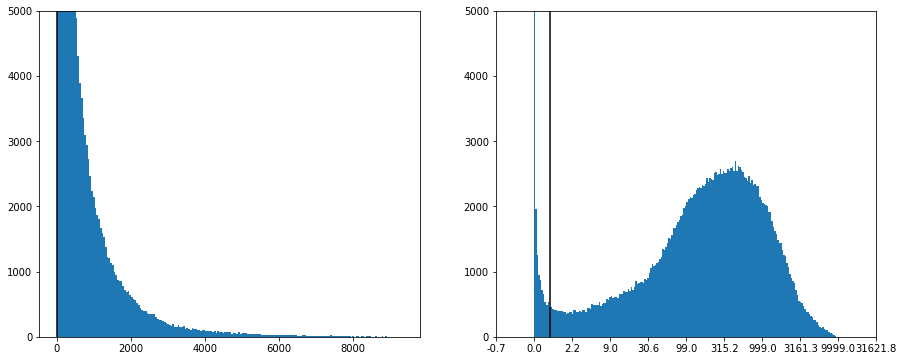

In [89]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lrt"] != 0]["lrt"], bins=200)
vlines([threshold_sel], 0, 5000)
ylim([0,5000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lrt"] != 0]["lrt"]+1), bins=200)
vlines(np.log10(threshold_sel+1), 0, 5000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,5000]);

In [90]:
lofar["lr_index_sel"] = lofar["lr_index"]
lofar["lr_index_sel"][lofar["lrt"] < threshold_sel] = np.nan

## Save combined catalogue

In [91]:
combined["lr_index_sel"] = combined_aux_index.astype(float)

In [92]:
pwl = join(lofar, combined, 
           join_type='left', 
           keys='lr_index_sel', 
           uniq_col_name='{col_name}{table_name}', 
           table_names=['_input', ''])

In [93]:
pwl_columns = pwl.colnames

In [94]:
for col in pwl_columns:
    fv = pwl[col].fill_value
    if (isinstance(fv, np.float64) and (fv != 1e+20)):
        print(col, fv)
        pwl[col].fill_value = 1e+20

dec 1.0
W1mag 1.0
i 1.0
colour 1.0
category 1.0


In [95]:
columns_save = ['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 
 'Peak_flux', 'E_Peak_flux', 'Total_flux', 'E_Total_flux', 
 'Maj', 'E_Maj', 'Min', 'E_Min', 'PA', 'E_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID',
 'AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr',
 'W1mag', 'W1magErr', 'i', 'iErr', 'colour', 'category',
 'lr', 'lr_dist']

In [96]:
pwl[columns_save].filled().write('lofar_pw_lara.fits', format="fits")